<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/QuantumApplicationAlgorithm_VAQ_VQE(MolecularGeometry_H2)_mkbahk_20251208.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [184]:
# Python 3.9 ~ 3.11 환경에서 아래 순서대로 설치
%pip install qiskit[visualization]==1.2.4
%pip install qiskit-aer==0.15.1
%pip install qiskit-algorithms==0.3.1
%pip install qiskit-nature[pyscf]==0.7.2
#%pip install pyscf==2.6.0
%pip install py3Dmol

In [185]:
import warnings
warnings.filterwarnings('ignore')

**Qiskit Nature**는 양자 컴퓨팅 알고리즘을 사용하여 양자 역학적 자연 과학 문제를 해결하는 데 도움을 주는 오픈 소스 프레임워크입니다. 여기에는 전자 및 진동 구조 문제의 바닥 상태와 여기 상태를 찾는 것, 분자 시스템의 쌍극자 모멘트를 측정하는 것, 격자 상에서 이징 모델과 페르미-허버드 모델을 푸는 것 등이 포함됩니다.

이 코드는 다음과 같은 다양한 모듈로 구성됩니다.
1. 화학 드라이버 또는 파일 형식에서 데이터 로딩
2. 2차 양자화 연산자 구성 및 조작
3. 2차 양자화 공간을 큐비트 공간으로 변환
4. 자연 과학 분야에 특화된 양자 회로 라이브러리.
<BR>Qiskit 알고리즘의 사용을 더욱 쉽고 편리하게 만들어주는 자연 과학 관련 알고리즘 및 유틸리티를 제공합니다.

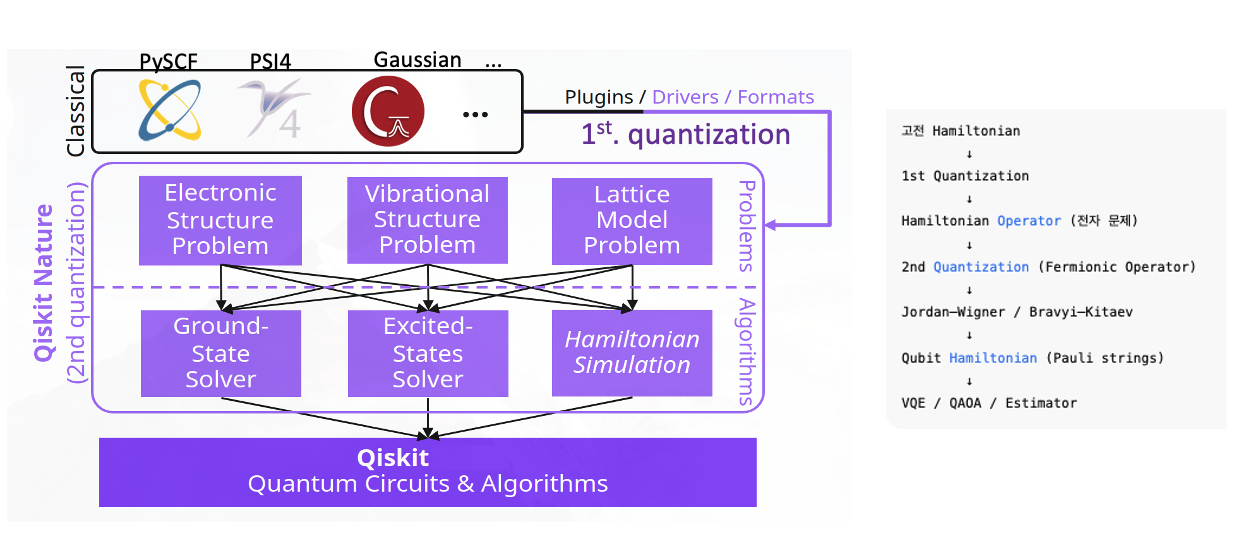

* First quantization — 고전 역학에서 양자 역학으로 넘어갈 때 위치와 운동량을 연산자로 바꾸는 과정
(예: Schrödinger 방정식). 전자좌표(Geometry)를 기반으로 바닥상태 에너지 계산, 파동함수 직접 근사, 전자수 증가-> 차원폭발, 양자컴퓨터에 직접 올리기 어려움. 전통적인 양자화학(HF, CI, DFT)의 출발점<BR>
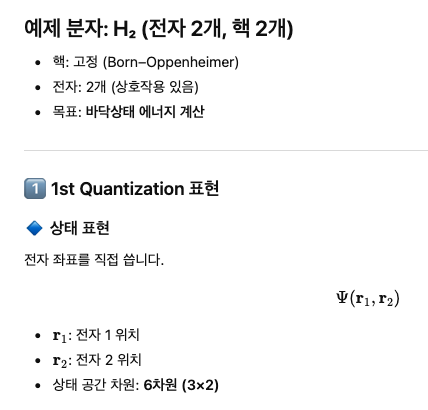

* Second quantization — 파동함수를 다시 "양자화"하여 필드 연산자(field operator)로 취급합니다. 입자를 생성(creation)하고 소멸(annihilation)하는 연산자를 도입하여, 입자 수가 고정되지 않은 상태나 동일 입자의 교환 대칭(페르미온의 반대칭, 보손의 대칭)을 자연스럽게 처리함.
좌표구조(Geometry)를 버리고 오비탈 기준으로 바꿈.<br>
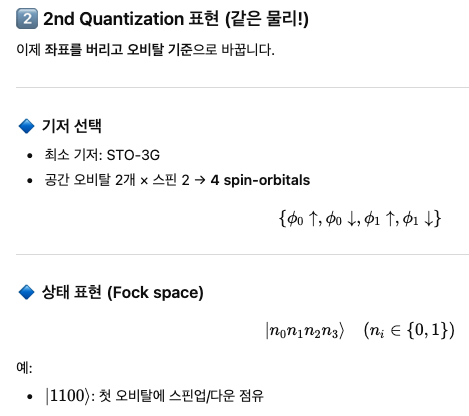

https://chatgpt.com/share/69603d89-b114-8001-873c-fa931c3fb46a

https://claude.ai/share/fc0c561e-24e3-4941-aa43-f5bb96e3e091

**VQE는 양자 시스템의 바닥 상태 에너지에 해당하는 해밀토니안의 기대값을 추정하도록 설계된 양자-고전 혼합 알고리즘입니다. 본질적으로, 분자 또는 물질의 에너지 지형을 탐색하는 양자 장치의 강력한 기능과 변분 매개변수를 최적화하는 고전 알고리즘의 계산 효율성을 결합한 알고리즘 입니다.**
<br>
예를들어 어떤 분자에 새로운 원자를 결합해 새로운 화홥물을 만드는 과정 중에서
1. 초기구조생성(Initial Structure Generation)
2. (VQE) 전자구조 계산-바닥상태에너지
3. (VQE Gradient | QAOA) 기하구조최적화(Geometry Optimization)
4. 진동수 계산(Frequency | Vibrational Analysis)
5. (VQE for each fragment | Quantim EDA(개발중)) 에너지 분석 및 결합 에너지 계산
6. 분자성질예측(Properties Calculation)<br>
중 주로 2단계에서 사용<br>
미래에는 QPE(Quantum Phase Eigensolver)로 변경될 것임


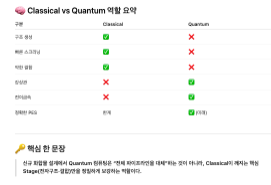

# **VQE (Variational Quantum Eigensolver) 구현<br>**
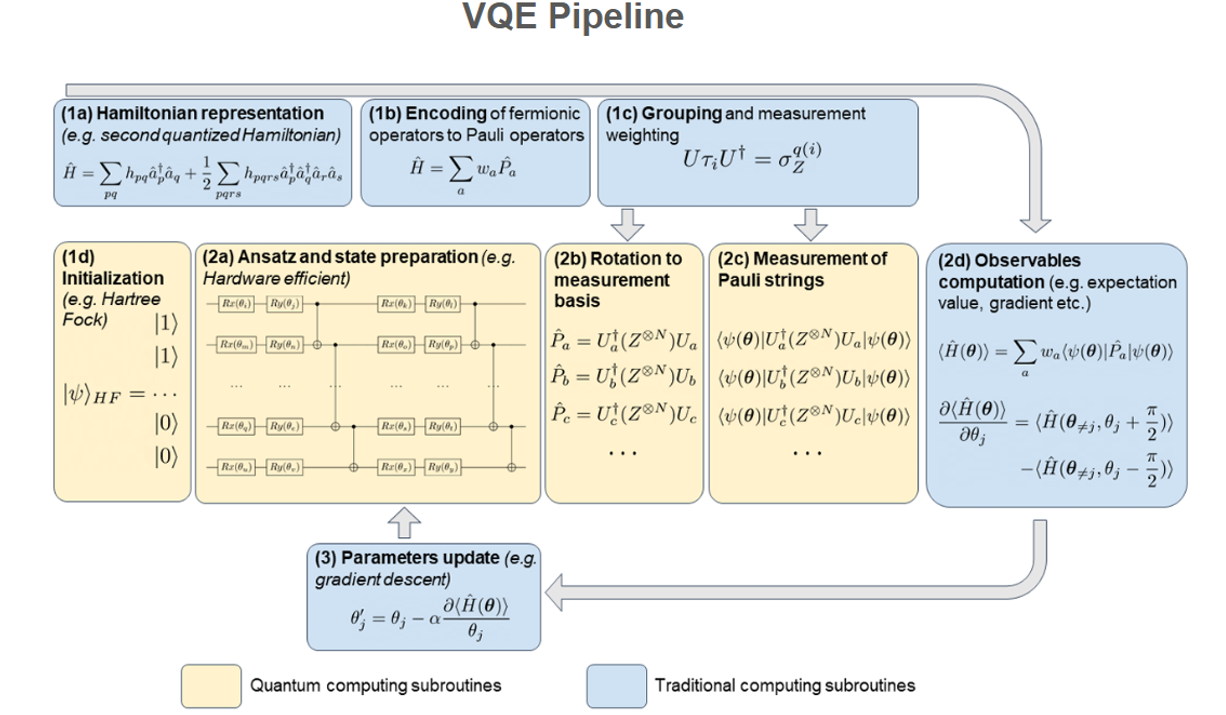


In [186]:
import numpy as np
import datetime
import time

# 분자 구조(좌표)를 입력할 때 길이의 단위를 명확하게 지정하기 위한 열거형(Enum) 클래스, Ångström이야? Bohr이야? nm이야?”
from qiskit_nature.units import DistanceUnit

#First quantization(제1 양자화): 실제 분자의 전자 구조(오비탈, 에너지, 1체/2체 적분 등)를 고전적으로 정확히 계산해서 양자 컴퓨터가 쓸 수 있는 2차 양자화 해밀토니안으로 바꿔주는 핵심 브릿지 역할, 쉽게 말해,
# H₂, H₂O, CH₄ 같은 분자를 주면, PySCF(하트리-포크 또는 DFT)로 분자 오비탈과 모든 적분을 계산해서 Qiskit이 VQE나 QAOA에 바로 넣을 수 있는 Pauli 문자열 해밀토니안으로 변환해 줌”
from qiskit_nature.second_q.drivers import PySCFDriver, Psi4Driver, GaussianDriver, ElectronicStructureDriver
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo

#Second quantization(제2 양자화): 양자 다체계 문제를 효율적으로 모델링하기 위한 핵심 기법입니다. 이는 생성(creation)과 소멸(annihilation) 연산자를 사용해 해밀토니안을 표현하는 방식으로,
# 각 Problem 클래스(ElectronicStructureProblem, VibrationalStructureProblem, LatticeModelProblem)는 second_q_ops() 메서드를 통해
# second-quantized operator(주로 FermionicOp 또는 BosonicOp 형태)를 생성합니다. 이 연산자는 이후 QubitMapper(Jordan-Wigner, Parity 등)를 통해 큐비트 연산자로 변환되어 양자 알고리즘(VQE 등)에서 사용
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper, BravyiKitaevMapper, TaperedQubitMapper, DirectMapper, QubitMapper

#실행하기 전에 분자 해밀토니안을 작고 계산 가능한 크기로 줄여주는 전처리 도구
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer, FreezeCoreTransformer, BasisTransformer

#from qiskit_nature.second_q.mappers.QubitConverter import QubitConverter
from qiskit_nature.second_q.problems import ElectronicStructureProblem, VibrationalStructureProblem, LatticeModelProblem
from qiskit_nature.second_q.algorithms import GroundStateSolver, GroundStateEigensolver, ExcitedStatesSolver, ExcitedStatesEigensolver, QEOM, QEOMResult, EvaluationRule

#Classical Optimizer
from qiskit_algorithms.optimizers import SLSQP, COBYLA, L_BFGS_B, SPSA, NFT, P_BFGS, QNSPSA, P_BFGS, ADAM, adam_amsgrad, NELDER_MEAD, POWELL, TNC, CG, NFT, IMFIL, SNOBFIT, BOBYQA, GSLS, AQGD

#Aanstz
from qiskit.circuit.library import TwoLocal, EfficientSU2, RealAmplitudes, ExcitationPreserving, PauliTwoDesign, NLocal

#Hartree-Fock (HF) 방법은 양자 화학에서 다전자 원자나 분자의 전자 구조를 근사적으로 계산하는 기본적인 방법입니다.
#"Hartree-Fock solution", 이 방법으로 얻어진 최적화된 파동함수와 에너지를 의미하며, 정확한 슈뢰딩거 방정식 해가 아닌 최선의 단일 Slater determinant 근사
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

#from qiskit_aer import AerSimulator
from qiskit.primitives import Estimator

from qiskit_algorithms import VQE

**물분자(H2O) 좌표계산법 예**

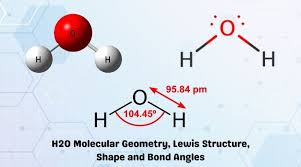

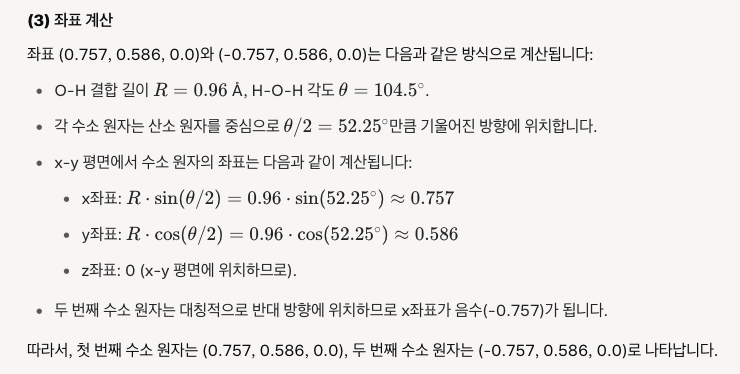

# 직접 Molecule 객체 만들 때 <br>
from qiskit_nature.second_q.molecule import Molecule<br>

molecule = Molecule(<br>
    geometry=[<br>
        ["H", [0.0, 0.0, 0.0]],<br>
        ["H", [0.0, 0.0, 1.4]]       <br>
    ],<br>
    unit=DistanceUnit.BOHR          #여기선 Bohr 단위로 주고 싶다면, 여기서 명시<br>
)

In [198]:
print("=" * 60)
print("VQE를 이용한 분자 에너지 계산")
print("=" * 60)


# 1. 분자 (구조)정의 (H2 분자)
print("-" * 60)
print("[1단계] 분자 구조 정의")
print("-" * 60)

# 0.1. 수소분자 정의
# 수소 분자 정의 (원자간 거리: 0.74 Angstrom)
h2 =  "H 0.0 0.0 0.0; H 0.0 0.0 0.74"

# 0.2. 분자 중심이 원점에 오는 대칭 버전
h2_center = "H 0.0 0.0 -0.37; \
             H 0.0 0.0 0.37"

# 0.3. Bohr 단위로 주고 싶을 때 (많은 양자화학 프로그램 기본 단위)
h2_bohr = "H 0.0 0.0 0.0; \
           H 0.0 0.0 1.4"   # 1.4 a.u. ≈ 0.74 Å

# 1. 물분자 H₂O (이미 있으시지만 참고용으로 다시)
h2o = "O 0.000000 0.000000 0.000000; \
       H 0.757000 0.586000 0.000000; \
       H -0.757000 0.586000 0.000000"

# 2. 메탄 CH₄ (Td 대칭)
ch4 = "C 0.000000 0.000000 0.000000; \
       H 0.626800 0.626800 0.626800; \
       H 0.626800 -0.626800 -0.626800; \
       H -0.626800 0.626800 -0.626800; \
       H -0.626800 -0.626800 0.626800"

# 3. 에틸렌 C₂H₄ (D2h 대칭, 평면 구조)
c2h4 = "C 0.000000 0.000000 0.669500; \
        C 0.000000 0.000000 -0.669500; \
        H 0.928900 0.000000 1.237500; \
        H -0.928900 0.000000 1.237500; \
        H 0.928900 0.000000 -1.237500; \
        H -0.928900 0.000000 -1.237500"

# 4. 암모니아 NH₃ (C3v 대칭)
nh3 = "N 0.000000 0.000000 0.000000; \
       H 0.000000 0.951000 -0.267000; \
       H 0.823000 -0.475500 -0.267000; \
       H -0.823000 -0.475500 -0.267000"

# 5. 이산화탄소 CO₂ (D∞h 대칭, 선형)
co2 = "O -1.161000 0.000000 0.000000; \
       C  0.000000 0.000000 0.000000; \
       O  1.161000 0.000000 0.000000"

# 6. 보너스: 아세틸렌 C₂H₂ (D∞h 대칭, 선형)
c2h2 = "C 0.000000 0.000000 0.601000; \
        C 0.000000 0.000000 -0.601000; \
        H 0.000000 0.000000 1.662000; \
        H 0.000000 0.000000 -1.662000"


#이 부분을 바꾸어 주세요.
molecule = h2

#H₂, H₂O, CH₄ 같은 분자를 주면, PySCF(하트리-포크 또는 DFT 방법)로 분자 오비탈과 모든 적분을 계산해서 Qiskit이 VQE나 QAOA에 바로 넣을 수 있는 Pauli 문자열 해밀토니안로 변경
#고전 계산화학 소프트웨어 패키지인 PySCF를 사용하여 페르미온 연산자를 구성하는 데 필요한 전자 궤도 기저에서의 1체 및 2체 적분을 계산합니다.->First Quantization

driver = PySCFDriver(
    atom=molecule,
    #basis="cc-pVDZ", #가장 정확하지만 시간이 너무 많이 걸려서 결과를 본적이 없음

    basis="sto3g",  # 분자오비탈 기저 함수(미분방정식 문제를 행렬 문제로 변환->계산가능하게, basis set = 계산의 기저 벡터 시스템, 무한 차원 Schrödinger 방정식이 유한 차원 행렬 고유치 문제로 변환
                    # Schrödinger 방정식 → 행렬 고유값 문제, Hamiltonian 생성, Fermionic operator 정의, Qubit Hamiltonian 변환의 기초
                    # 이 기저 위에서 모든 연산자(해밀토니안, overlap, dipole 등)를 행렬로 바꿔서 대각화·고유치 문제를 풀게 됨
                    # 전자 궤도(Slater-Type Orbital) 하나를 모사하기 위해, 계산이 쉬운 3개의 가우시안(Gaussian) 함수를 겹쳐서 근사했다는 뜻
                    # 계산정확도와 비용을 결정, "sto3g→매우빠름 교육용", "cc-pvdz→실전표준",  "def2-tzvp→고정밀"
    charge=0,       # 분자의 전체 전하, 중성 분자는 0(99%), 양이온 +1(LiH⁺, H₂⁺ 등), 음이온 -1(OH⁻ 등)
    spin=0,         # spin 옵션은 분자 내에 존재하는 홀전자의 개수를 정의하는 파라미터. 화학 및 양자 역학 계산에서 시스템의 자기적 성질을 결정하는 중요한 설정, 스핀다중도(Spin multiplicity) 2S+1
                    # (0 = singlet 모든 전자가 쌍을 이룸, 닫힌껍질(H₂, H₂O, CO, N2, CH₄ 등 대부분)), 1 = doublet 전자하나가 1개 있음, 홀전자 1개(OH 라디칼 CH3, OH), 2 = triplet 홀전자가 2개 있음(O₂ triplet), …)
                    # spin = N_α(Up spin) − N_β(Down spin) = 2S
    unit=DistanceUnit.ANGSTROM
)

###
##어떤 분자를, 어떤 단위로, 어떤 기저함수로, 몇 개의 전하와 스핀을 갖고 계산할까?
##를 완전히 결정하는 부분. 이 5개만 제대로 설정하면 나머지는 Qiskit이 알아서 다 해줌
###

VQE를 이용한 분자 에너지 계산
------------------------------------------------------------
[1단계] 분자 구조 정의
------------------------------------------------------------


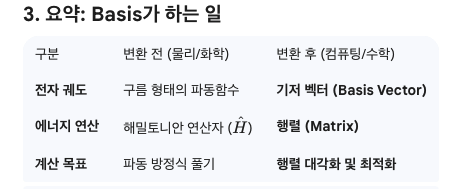

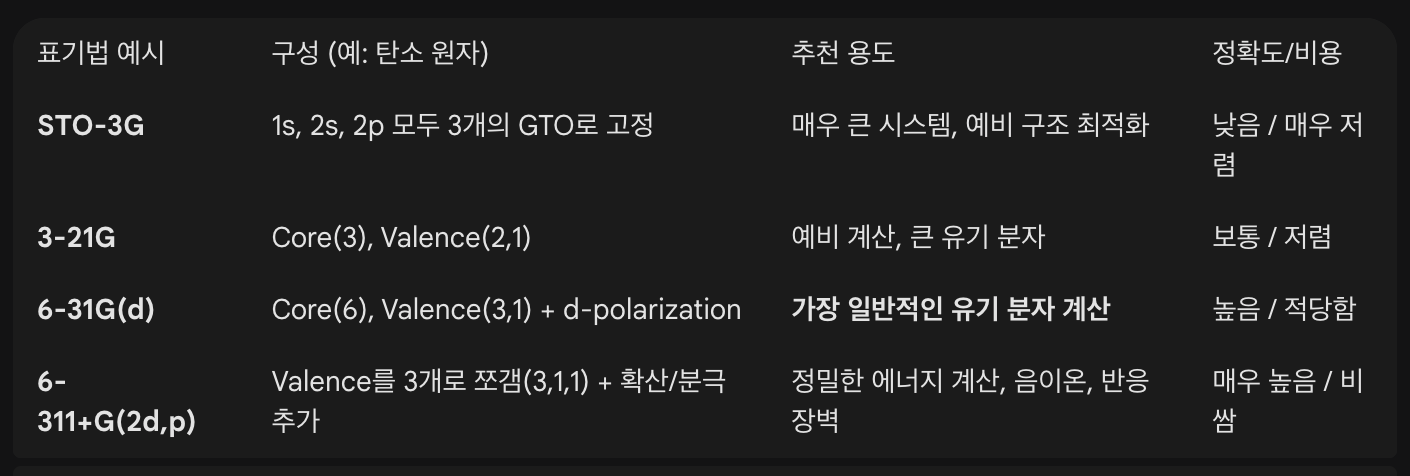

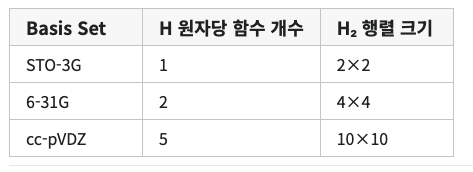

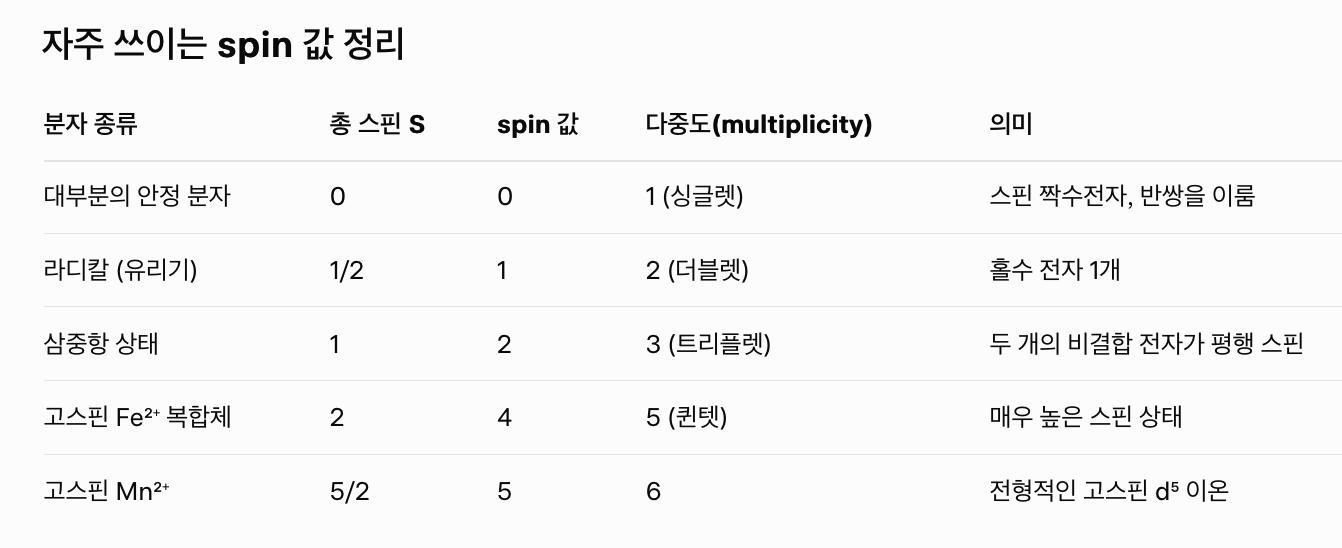

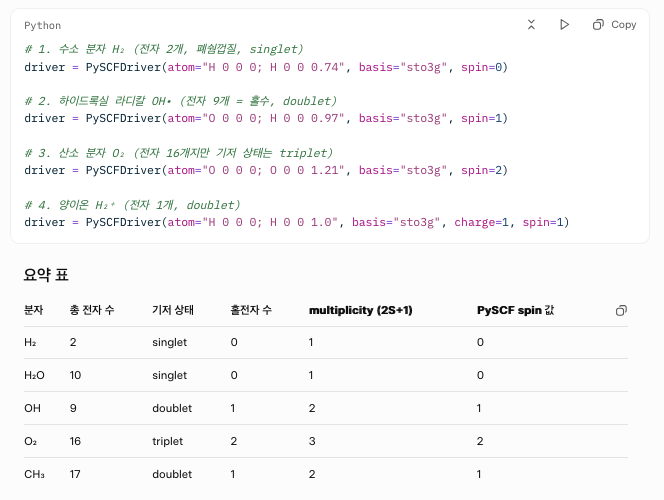

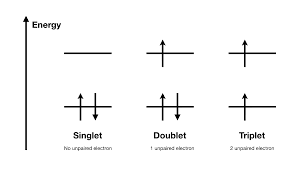

In [199]:
import py3Dmol

def visualize_molecule(molecule_string, title="Molecule Visualization"):
    # Parse the molecule string into XYZ format
    atoms_data = molecule_string.strip().split(';')
    num_atoms = len(atoms_data)

    xyz_string = f"{num_atoms}\n{title}\n"
    atom_list = [] # Store atom details for individual labeling
    for atom_info in atoms_data:
        parts = atom_info.strip().split()
        if len(parts) == 4:  # Atom symbol and 3 coordinates
            atom_symbol = parts[0]
            x, y, z = float(parts[1]), float(parts[2]), float(parts[3])
            xyz_string += f"{atom_symbol} {x:.6f} {y:.6f} {z:.6f}\n"
            atom_list.append({"atom": atom_symbol, "x": x, "y": y, "z": z}) # Store for individual labels
        else:
            print(f"Warning: Could not parse atom info: {atom_info}")
            continue
        ###if
    ###for

    # Create a 3Dmol view
    view = py3Dmol.view(width=800, height=600)
    view.addModel(xyz_string, 'xyz')
    view.setStyle({'stick':{'colorscheme':'byElement'}, 'sphere':{'scale':0.3, 'colorscheme':'byElement'}}) # Keep stick and sphere styles

    # Add labels for each atom explicitly
    for i, atom_data in enumerate(atom_list):
        view.addLabel(atom_data["atom"], {
            "position": {"x": atom_data["x"], "y": atom_data["y"], "z": atom_data["z"]},
            "font": 'sans-serif',
            "fontSize": 12,
            "fontColor": 'black',
            "showBackground": True,
            "backgroundColor": 'white' # Added background color for visibility
        })
    ###for

    view.zoomTo()
    view.show()
###def

In [200]:
# Visualize the currently selected molecule
visualize_molecule(molecule, "Selected Molecule")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [201]:
# 2. 전자 구조 문제 설정
print("-" * 60)
print("[2단계] 전자 구조 문제 설정")
print("-" * 60)

problem = driver.run()  # ← 여기서 모든 고전 계산이 일어남!
print(f"분자 (공간)궤도 개수: {problem.num_spatial_orbitals}") #스핀을 고려하지 않은 순수한 공간 함수(molecular orbital, MO)
print(f"전자 개수: {problem.num_particles}")

# Hamiltonian 얻기
hamiltonian = problem.hamiltonian.second_q_op()  # Fermionic Hamiltonian

------------------------------------------------------------
[2단계] 전자 구조 문제 설정
------------------------------------------------------------
분자 (공간)궤도 개수: 2
전자 개수: (1, 1)


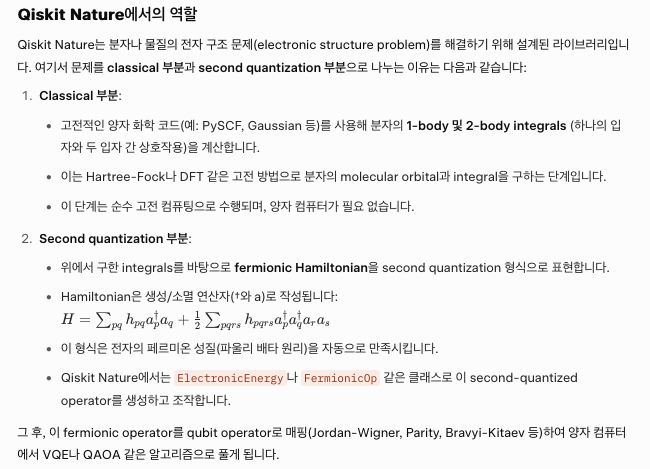

In [202]:
#number spin orbitals: 이 해밀토니안이 작용하는 스핀 오비탈(spin orbital)의 총 개수
#number terms: second-quantized fermionic 해밀토니안에 포함된 독립적인 Pauli-like term(연산자 문자열)의 개수를 의미
print(hamiltonian)

Fermionic Operator
number spin orbitals=4, number terms=36
  -1.2533097866459775 * ( +_0 -_0 )
+ -0.4750688487721778 * ( +_1 -_1 )
+ -1.2533097866459775 * ( +_2 -_2 )
+ -0.4750688487721778 * ( +_3 -_3 )
+ 0.33737796340722415 * ( +_0 +_0 -_0 -_0 )
+ 0.33185570067540676 * ( +_0 +_1 -_1 -_0 )
+ 0.33737796340722415 * ( +_0 +_2 -_2 -_0 )
+ 0.33185570067540676 * ( +_0 +_3 -_3 -_0 )
+ 0.09060523100759853 * ( +_0 +_0 -_1 -_1 )
+ 0.09060523100759853 * ( +_0 +_1 -_0 -_1 )
+ 0.09060523100759853 * ( +_0 +_2 -_3 -_1 )
+ 0.09060523100759853 * ( +_0 +_3 -_2 -_1 )
+ 0.09060523100759853 * ( +_1 +_0 -_1 -_0 )
+ 0.09060523100759853 * ( +_1 +_1 -_0 -_0 )
+ 0.09060523100759853 * ( +_1 +_2 -_3 -_0 )
+ 0.09060523100759853 * ( +_1 +_3 -_2 -_0 )
+ 0.33185570067540676 * ( +_1 +_0 -_0 -_1 )
+ 0.34882575224523144 * ( +_1 +_1 -_1 -_1 )
+ 0.33185570067540676 * ( +_1 +_2 -_2 -_1 )
+ 0.34882575224523144 * ( +_1 +_3 -_3 -_1 )
+ 0.33737796340722415 * ( +_2 +_0 -_0 -_2 )
+ 0.33185570067540676 * ( +_2 +_1 -_1 -_2 )
+ 0.3

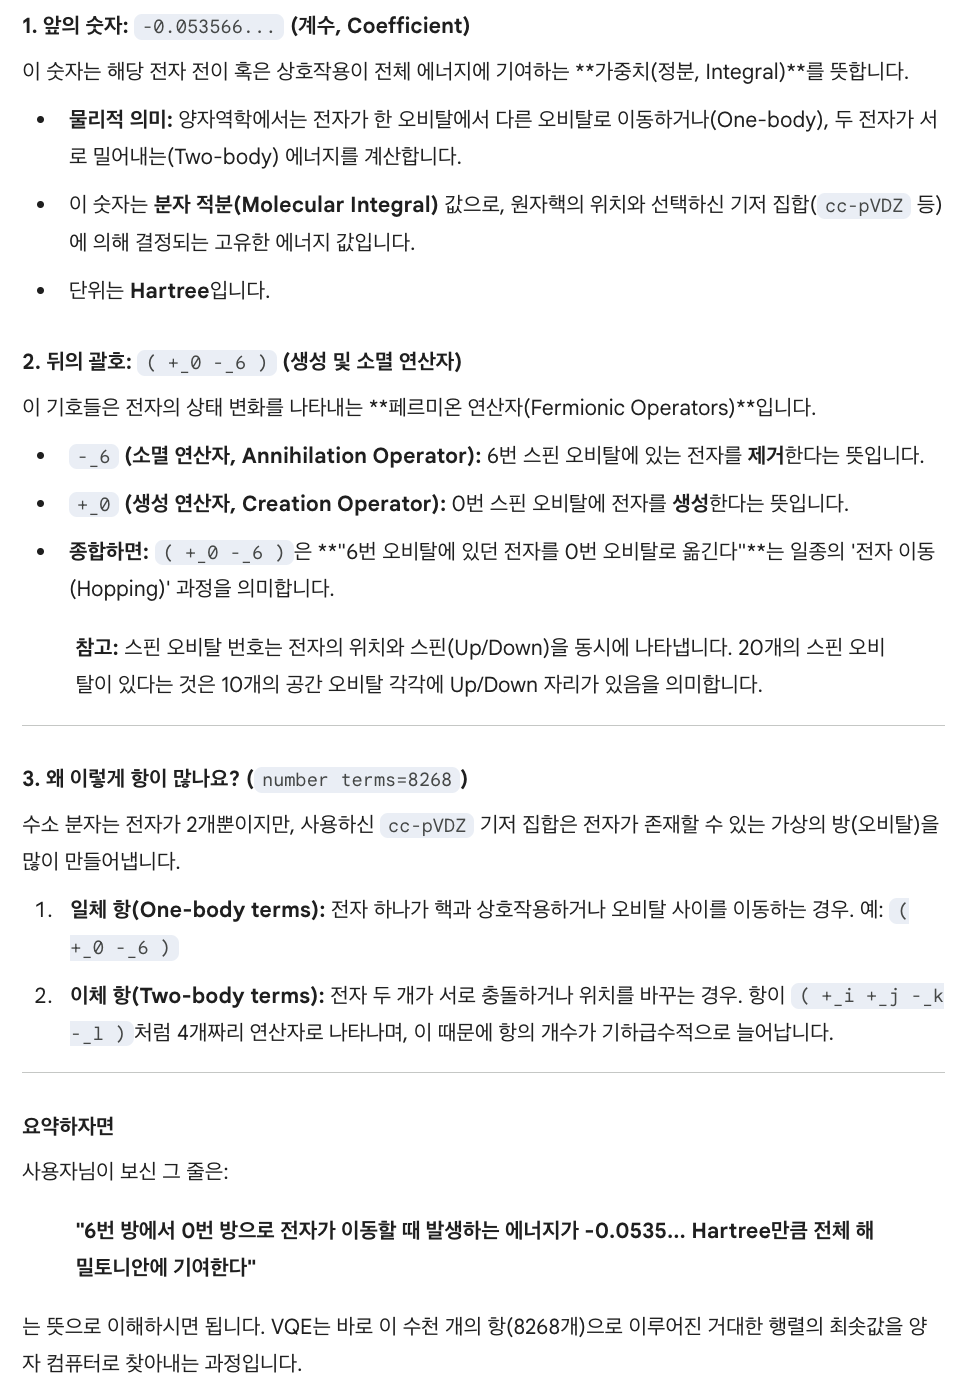

In [203]:
# 정확한 최적에너지를 구하기 위해서 핵-핵 상수항(값)을 구해놓습니다.
nuclear_repulsion_energy = problem.nuclear_repulsion_energy
print(f"Nuclear Repulsion Energy: {nuclear_repulsion_energy} Hartree")

Nuclear Repulsion Energy: 0.7151043390810812 Hartree


양자 컴퓨터(VQE 등)에서는 이 Fermionic Operator를 Jordan-Wigner 등의 변환으로 qubit Hamiltonian으로 바꾼 후, ground state를 찾아 총 에너지를 구합니다.

In [204]:
# 3. Qubit Mapping (Jordan-Wigner 변환)
print("-" * 60)
print("[3단계] Qubit Mapping(Fermonic Hamiltionian->Qubit Hamiltonian)")
print("-" * 60)

mapper = JordanWignerMapper()
#mapper = ParityMapper()
#mapper = BravyiKitaevMapper()
#mapper = TaperedQubitMapper(ParityMapper())
#mapper = DirectMapper()
#mapper = QubitMapper() //에러발생

qubit_op = mapper.map(hamiltonian)

print(f"필요한 큐비트 개수: {qubit_op.num_qubits}")
print(f"Pauli 항의 개수: {len(qubit_op)}")

------------------------------------------------------------
[3단계] Qubit Mapping(Fermonic Hamiltionian->Qubit Hamiltonian)
------------------------------------------------------------
필요한 큐비트 개수: 4
Pauli 항의 개수: 15


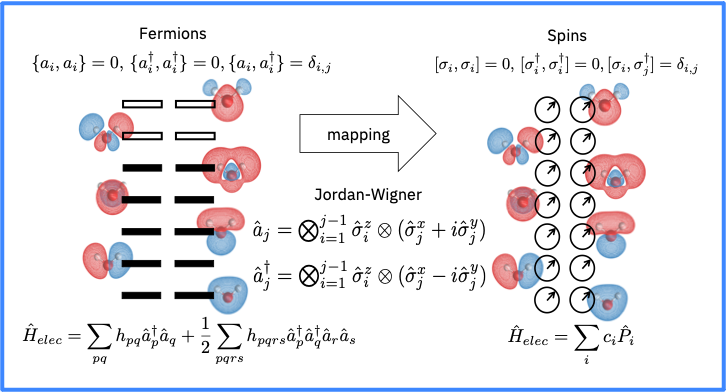

In [205]:
for pauli, coeff in sorted(qubit_op.label_iter()):
    print(f"{coeff.real:+.8f} * {pauli}")
###for

-0.81217061 * IIII
+0.17141283 * IIIZ
-0.22343154 * IIZI
+0.12062523 * IIZZ
+0.17141283 * IZII
+0.16868898 * IZIZ
+0.16592785 * IZZI
+0.04530262 * XXXX
+0.04530262 * XXYY
+0.04530262 * YYXX
+0.04530262 * YYYY
-0.22343154 * ZIII
+0.16592785 * ZIIZ
+0.17441288 * ZIZI
+0.12062523 * ZZII


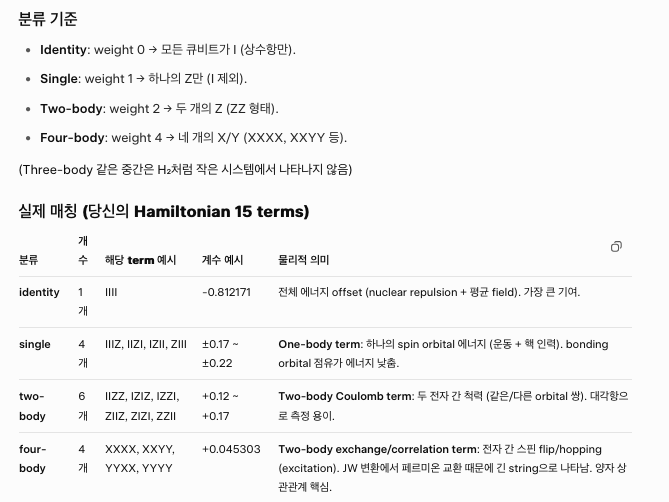

4큐비트라 매우 작아서 고전 컴퓨터로도 정확히 풀 수 있지만, 더 큰 분자(LiH, H2O 등)로 가면 큐비트 수가 늘어나 양자 우위가 나타납니다

In [206]:
#print("-" * 60)
#print("[3.5단계] Active Space Reduction (선택 사항)")
#print("-" * 60)

# ActiveSpaceTransformer를 사용하여 활성 공간을 정의하고 Hamiltonian의 크기를 줄입니다.
# num_electrons: 활성 공간에 포함될 전자의 총 개수 (튜플 형태로 alpha, beta 전자 수 지정 가능)
# num_spatial_orbitals: 활성 공간에 포함될 공간 궤도의 총 개수
# H2O 분자의 경우, 초기 problem은 (5,5) 전자와 7개의 공간 궤도를 가집니다.
# 여기서는 2개의 전자 (1alpha, 1beta)를 2개의 공간 궤도에 할당하는 활성 공간을 설정합니다.
# 이는 가장 기본적인 활성 공간 축소 전략 중 하나로, 계산 비용을 크게 줄일 수 있습니다.
#transformer = ActiveSpaceTransformer(
#    num_electrons=(1, 1),            # 활성 공간에 포함될 alpha, beta 전자 수 (총 2전자)
#    num_spatial_orbitals=2           # 활성 공간에 포함될 공간 궤도 수
#)

# ActiveSpaceTransformer를 problem 객체에 적용
# 이 과정에서 Hamiltonian의 차원이 줄어들고, 새로운 전자 구조 문제가 생성됩니다.
#problem_reduced = transformer.transform(problem)

# 줄어든 Hamiltonian으로 큐비트 연산자 다시 생성
# 이미 정의된 JordanWignerMapper를 사용합니다.
#hamiltonian_reduced = problem_reduced.hamiltonian.second_q_op()
#qubit_op = mapper.map(hamiltonian_reduced)

#print(f"줄어든 분자 궤도 개수: {problem_reduced.num_spatial_orbitals}")
#print(f"줄어든 전자 개수: {problem_reduced.num_particles}")
#print(f"줄어든 활성 공간에서 필요한 큐비트 개수: {qubit_op.num_qubits}")
#print(f"줄어든 활성 공간에서 Pauli 항의 개수: {len(qubit_op)}")

In [207]:
# 4. Ansatz 정의 (양자 회로)
print("-" * 60)
print("[4단계] Ansatz (Variational Form) 정의")
print("-" * 60)

num_qubits = qubit_op.num_qubits

# 가장 표준적인 형태 (논문의 90%가 이걸 씀)
#ansatz = EfficientSU2(num_qubits=num_qubits, reps=3, entanglement='linear', insert_barriers=True)

# TwoLocal ansatz 사용
#ansatz = TwoLocal(num_qubits=num_qubits, rotation_blocks=['ry', 'rz'], entanglement_blocks='cz', entanglement='linear', reps=2, insert_barriers=True)
#print(f"Ansatz 타입: TwoLocal \n회전 게이트: RY, RZ\n얽힘 게이트: CZ \n 반복 횟수: 2 \n파라미터 개수: {ansatz.num_parameters} ")

# 실수 파라미터만 쓰고 싶을 때
#ansatz = RealAmplitudes(num_qubits=8, reps=3, entanglement='linear')

# expressivity를 더 높이고 싶을 때 (작은 시스템)
#ansatz = TwoLocal(num_qubits=8, rotation_blocks=['ry', 'rz'], entanglement_blocks='cx', entanglement='sca', reps=5)

# 정확도 높지만 계산시간 많이 걸림.
ansatz = UCCSD(problem.num_spatial_orbitals, problem.num_particles, mapper, initial_state=HartreeFock(problem.num_spatial_orbitals, problem.num_particles,mapper))

------------------------------------------------------------
[4단계] Ansatz (Variational Form) 정의
------------------------------------------------------------


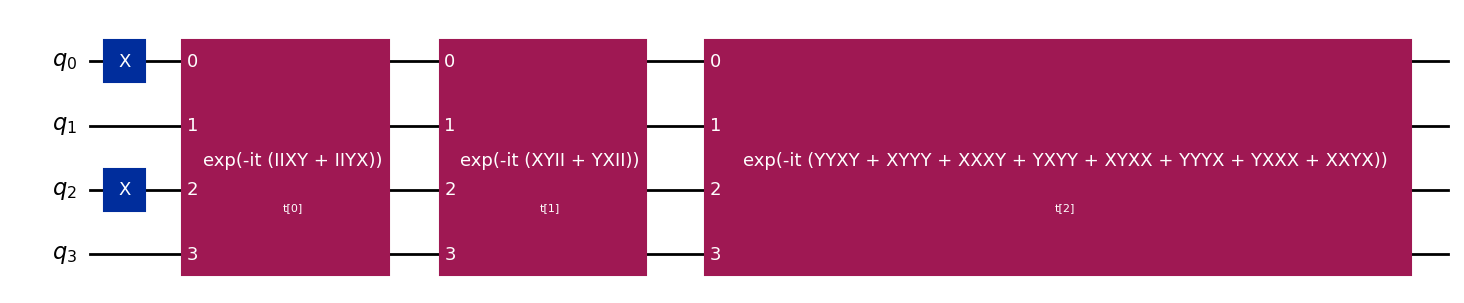

In [208]:
ansatz.decompose().draw("mpl")
#ansatz.decompose().draw()

In [209]:
# 5. 시뮬레이터 설정
print("-" * 60)
print("[5단계] 양자 시뮬레이터 설정")
print("-" * 60)

#backend = AerSimulator()
#print(f"백엔드: {backend.name}")

# Estimator 설정 (Qiskit 내부에 내장된 Primitives형 Simulator)
estimator = Estimator()


------------------------------------------------------------
[5단계] 양자 시뮬레이터 설정
------------------------------------------------------------


In [210]:
# 6. Optimizer 설정
print("-" * 60)
print("[6단계] Classical Optimizer 설정")
print("-" * 60)

#optimizer = SLSQP(maxiter=4082)
#print(f"Optimizer: SLSQP \n 최대 반복 횟수: 4082")

# 1. 가장 많이 쓰이고 안정적인 최적 선택 (추천 1순위), 본 AER사용 예제에서는 수렴못함
#optimizer = SPSA(maxiter=1000, learning_rate=0.1, perturbation=0.05, second_order=True)

# 2. 노이즈가 심한 실제 양자 하드웨어에서 가장 강력한 선택, 본 AER사용 예제에서는 수렴않됨
#optimizer = SPSA(maxiter=2000, blocking=False, allowed_increase=0.1, learning_rate=0.05,  perturbation=0.01,  second_order=True, resamplings={1: 10, 50: 5, 100: 3})

# 3. 시뮬레이터에서 빠르고 정확하게 수렴시키고 싶을 때 (추천), 본 AER사용 예제에서 최상의 결과
#optimizer = COBYLA(maxiter=2000, tol=1e-7, rhobeg=1.0)

# 4. 시뮬레이터에서 가장 정확한 결과가 필요할 때, 본 AER사용 최고의 결과가 나옴
optimizer = L_BFGS_B(maxfun=5000, maxiter=3000, ftol=1e-12, iprint=1)

# 5. QAOA에서 가장 많이 검증된 설정
#optimizer = NFT(maxiter=500, maxfev=10000)

# 6. 최신 Qiskit에서 성능 좋은 Gradient 기반 (Simulator 전용), 좋은 결과
#optimizer = P_BFGS(maxfun=10000, ftol=1e-9)

------------------------------------------------------------
[6단계] Classical Optimizer 설정
------------------------------------------------------------


In [211]:
# 7. VQE 실행
print("\n[7단계] VQE 알고리즘 실행")
print("-" * 60)
print("최적화 진행...")

# 현재 시간 보관 (시작 시간)
start_time = datetime.datetime.now()

# 현재 시작 시간 표시
print(f"루틴 시작 시간: {start_time.strftime('%H시 %M분 %S초')}")

#수렴과정을 그래프로 그리기 위해 중간 상태 보관
cost_history = []
def store_intermediate_result(eval_count, parameters, mean, std):
  # 루틴 종료 시간
  end_time = datetime.datetime.now()
  # 시작 시간과 종료 시간의 차이 계산
  time_diff = end_time - start_time

  # 시:분:초로 표시
  total_seconds = int(time_diff.total_seconds())
  hours = total_seconds // 3600
  minutes = (total_seconds % 3600) // 60
  seconds = total_seconds % 60

  #print(f"총 실행 시간: {hours:02d}시 {minutes:02d}분 {seconds:02d}초")
  print(eval_count," 단계: ", mean, f"\t\t총 실행 시간: {hours:02d}시 {minutes:02d}분 {seconds:02d}초")
  cost_history.append(mean)
###def

# 초기 파라미터 설정
initial_point = np.random.random(ansatz.num_parameters)
#initial_point = HartreeFock(problem.num_spatial_orbitals, problem.num_particles, mapper)

# VQE 인스턴스 생성
vqe = VQE(
    estimator=estimator,
    ansatz=ansatz,
    optimizer=optimizer,
    initial_point=initial_point,
    callback=store_intermediate_result
)

# VQE 실행
result = vqe.compute_minimum_eigenvalue(qubit_op)

#algorithm = GroundStateEigensolver(mapper, vqe)
#electronic_structure_result = algorithm.solve(problem)
#electronic_structure_result.formatting_precision = 6

#print(electronic_structure_result)


print("최적화 완료!!!")

# 루틴 종료 시간
end_time = datetime.datetime.now()
print(f"루틴 종료 시간: {end_time.strftime('%H시 %M분 %S초')}")

# 시작 시간과 종료 시간의 차이 계산
time_diff = end_time - start_time

# 시:분:초로 표시
total_seconds = int(time_diff.total_seconds())
hours = total_seconds // 3600
minutes = (total_seconds % 3600) // 60
seconds = total_seconds % 60

print(f"총 실행 시간: {hours:02d}시 {minutes:02d}분 {seconds:02d}초")


[7단계] VQE 알고리즘 실행
------------------------------------------------------------
최적화 진행...
루틴 시작 시간: 04시 40분 01초
1  단계:  -1.1461379737129995 		총 실행 시간: 00시 00분 00초
2  단계:  -1.1461379682587216 		총 실행 시간: 00시 00분 00초
3  단계:  -1.1461379697642746 		총 실행 시간: 00시 00분 00초
4  단계:  -1.1461379593831562 		총 실행 시간: 00시 00분 00초
5  단계:  -1.7292926166664662 		총 실행 시간: 00시 00분 00초
6  단계:  -1.7292926189625129 		총 실행 시간: 00시 00분 00초
7  단계:  -1.729292615588558 		총 실행 시간: 00시 00분 00초
8  단계:  -1.7292926244840778 		총 실행 시간: 00시 00분 00초
9  단계:  -1.8447610283849063 		총 실행 시간: 00시 00분 00초
10  단계:  -1.844761029251023 		총 실행 시간: 00시 00분 00초
11  단계:  -1.844761028368066 		총 실행 시간: 00시 00분 00초
12  단계:  -1.8447610266660817 		총 실행 시간: 00시 00분 00초
13  단계:  -1.8510857006345685 		총 실행 시간: 00시 00분 00초
14  단계:  -1.8510857012037347 		총 실행 시간: 00시 00분 00초
15  단계:  -1.8510857004998134 		총 실행 시간: 00시 00분 00초
16  단계:  -1.851085700526204 		총 실행 시간: 00시 00분 00초
17  단계:  -1.8521628216605404 		총 실행 시간: 00시 00분 00초
18  단계:  -1.85216

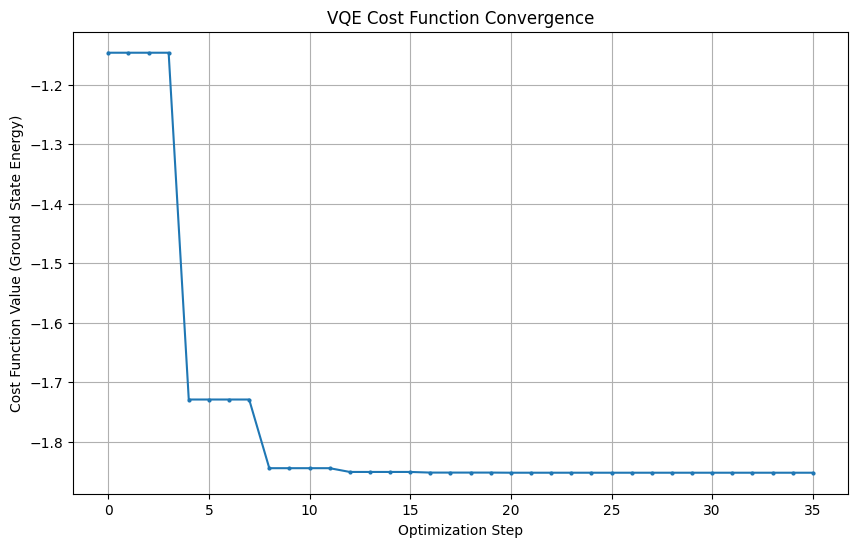

In [212]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(cost_history, marker='o', linestyle='-', markersize=2)
plt.title('VQE Cost Function Convergence')
plt.xlabel('Optimization Step')
plt.ylabel('Cost Function Value (Ground State Energy)')
plt.grid(True)
plt.show()

In [213]:
# 8. 결과 출력
print("\n" + "=" * 60)
print("VQE 결과")
print("=" * 60)

print(f"\n최적 에너지 (VQE): {result.eigenvalue.real:.6f} Hartree")
print(f"최적 파라미터 개수: {len(result.optimal_point)}")
print(f"Optimizer 평가 횟수: {result.cost_function_evals}")


VQE 결과

최적 에너지 (VQE): -1.852388 Hartree
최적 파라미터 개수: 3
Optimizer 평가 횟수: 36


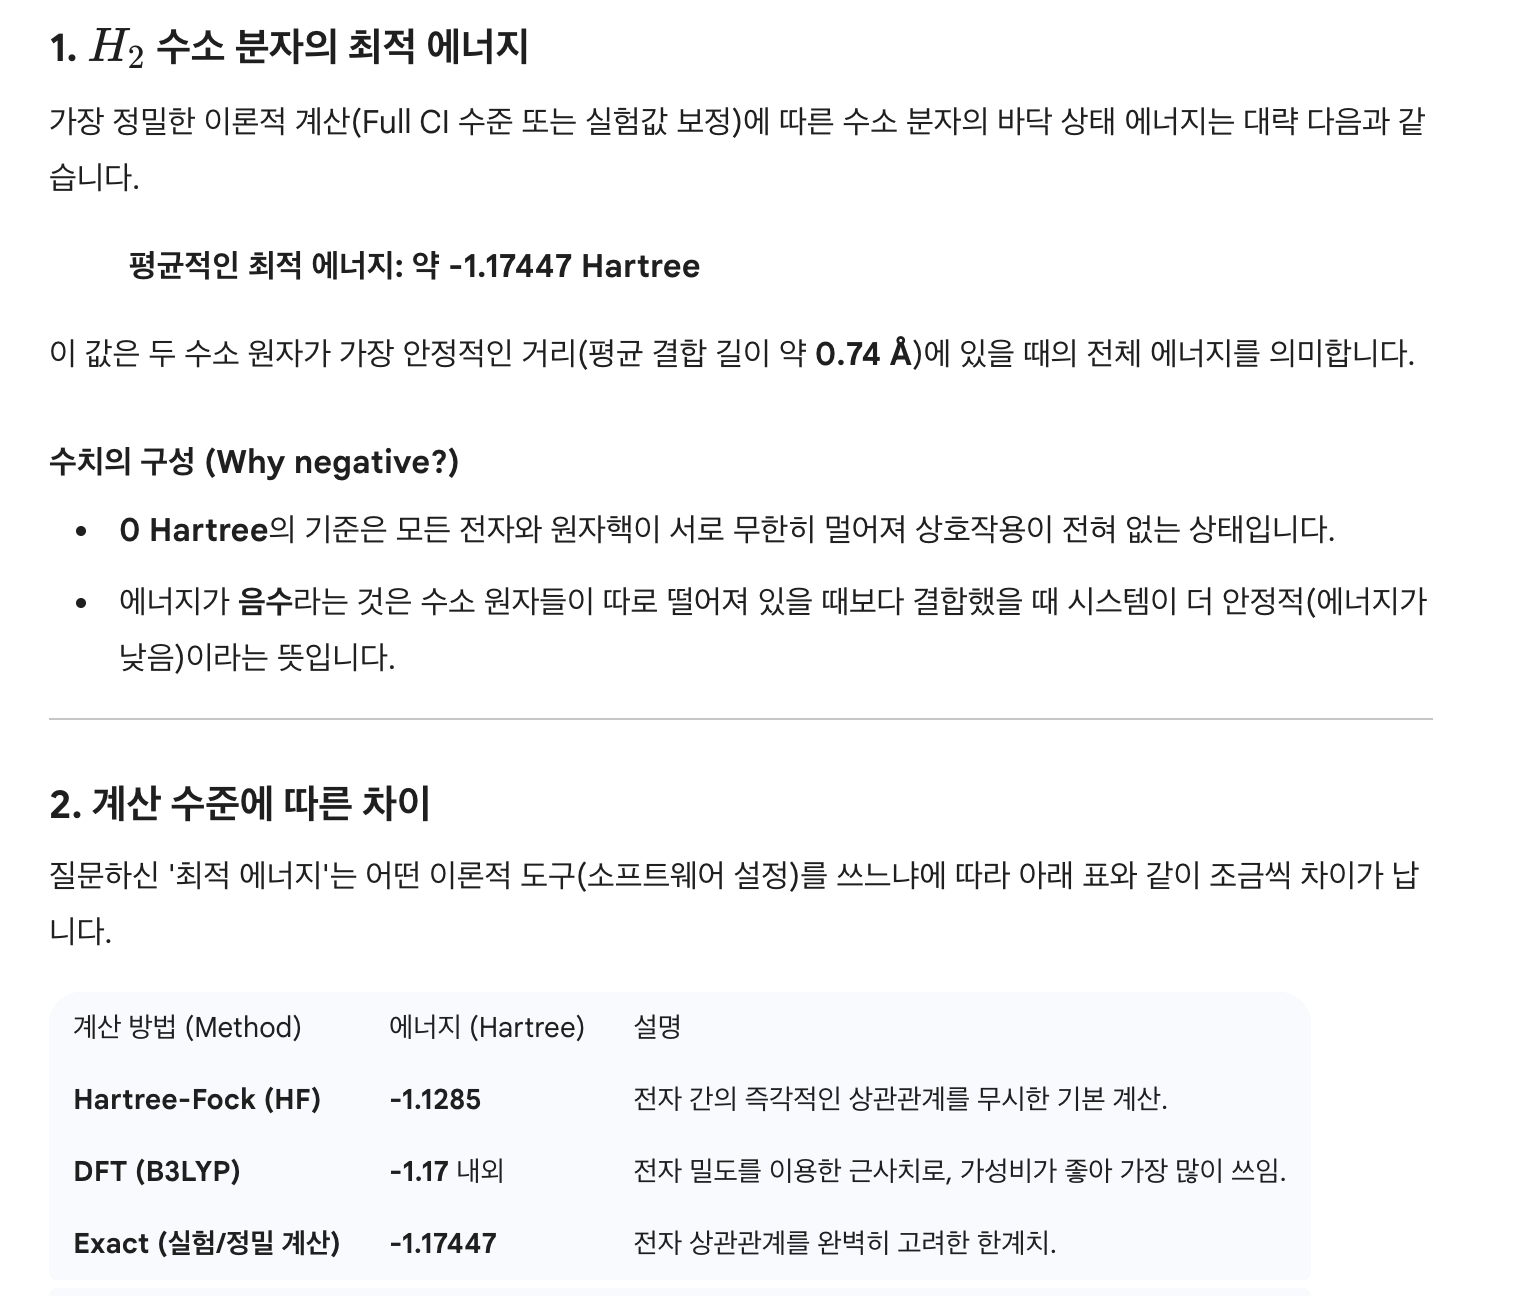

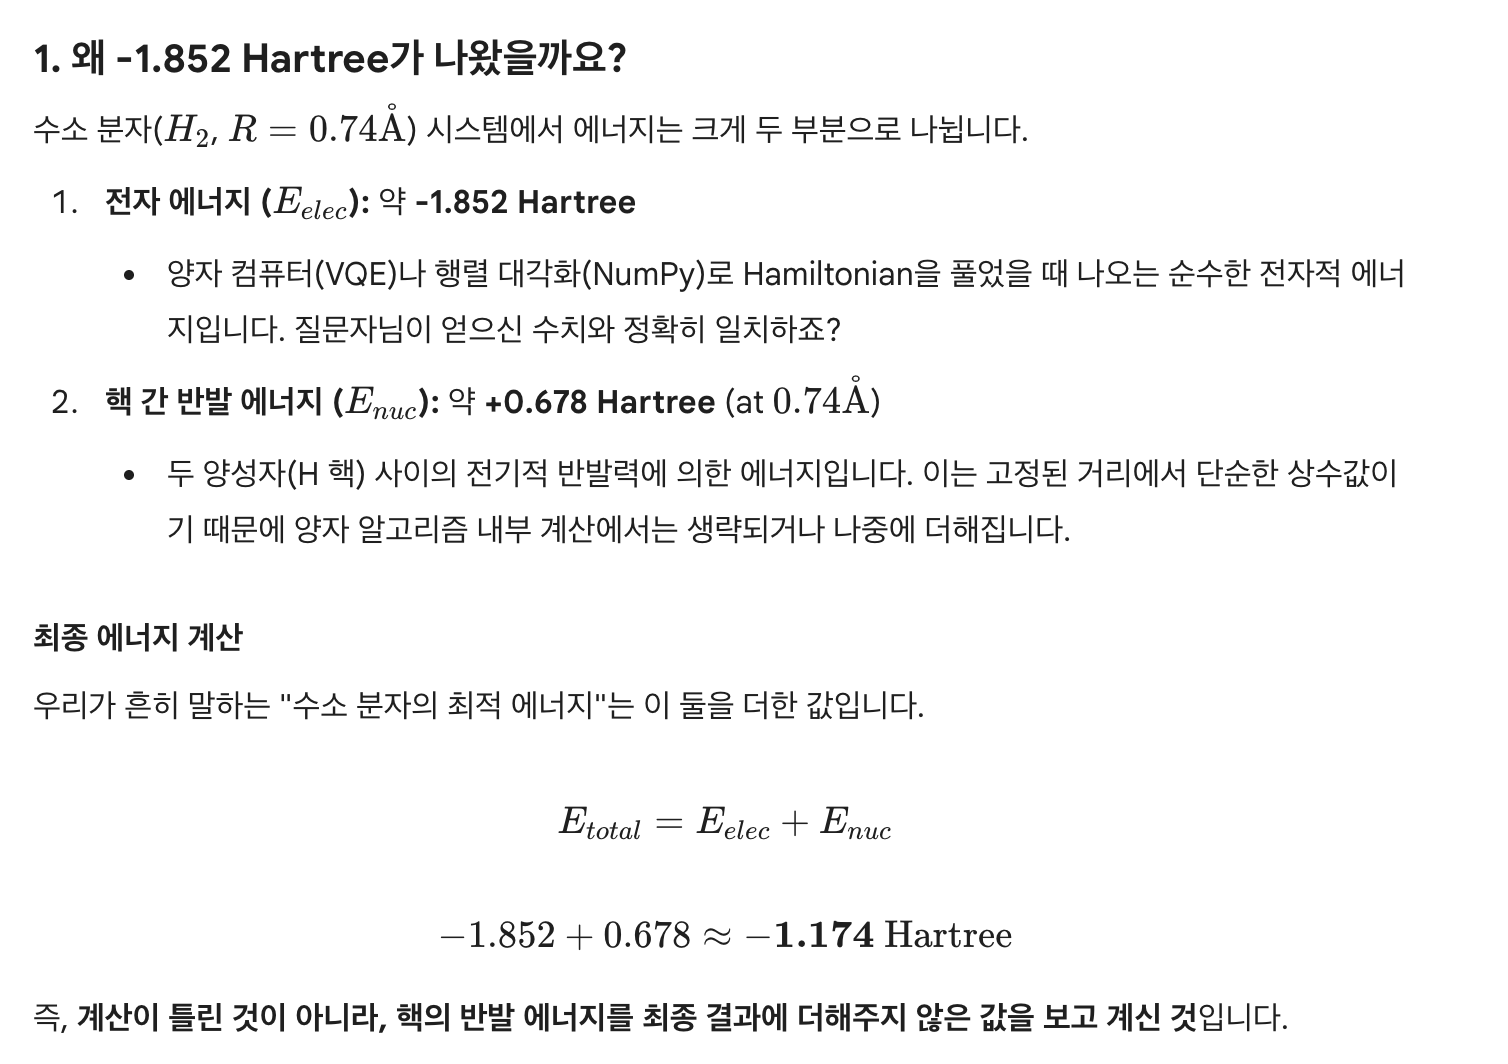

In [214]:
print(f"\n(핵-핵상수+최적에너지(VQE): {result.eigenvalue.real + nuclear_repulsion_energy:.6f} Hartree")


(핵-핵상수+최적에너지(VQE): -1.137284 Hartree


In [215]:
# 9. 정확한 해와 비교 (Classical 계산)
print("-" * 60)
print("[비교] Classical Exact Eigensolver")
print("-" * 60)

from qiskit_algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()
exact_result = numpy_solver.compute_minimum_eigenvalue(qubit_op)

print(f"정확한 에너지: {exact_result.eigenvalue.real+  nuclear_repulsion_energy:.6f} Hartree")

# 오차 계산
error = abs((result.eigenvalue.real + nuclear_repulsion_energy)- exact_result.eigenvalue.real)
print(f"\n에너지 오차: {error:.6f} Hartree")
print(f"상대 오차: {(error / abs(exact_result.eigenvalue.real)) * 100:.4f}%")

------------------------------------------------------------
[비교] Classical Exact Eigensolver
------------------------------------------------------------
정확한 에너지: -1.137284 Hartree

에너지 오차: 0.715104 Hartree
상대 오차: 38.6045%


In [216]:
# 10. 추가 정보
print("\n" + "=" * 60)
print("추가 정보")
print("=" * 60)

# 에너지를 다른 단위로 변환 (Hartree to eV)
hartree_to_ev = 27.211386245988
vqe_energy_ev = result.eigenvalue.real * hartree_to_ev
exact_energy_ev = exact_result.eigenvalue.real * hartree_to_ev

print(f"\nVQE 에너지: {vqe_energy_ev:.6f} eV")
print(f"정확한 에너지: {exact_energy_ev:.6f} eV")

print("\n" + "=" * 60)
print("계산 완료!")
print("=" * 60)


추가 정보

VQE 에너지: -50.406050 eV
정확한 에너지: -50.406050 eV

계산 완료!


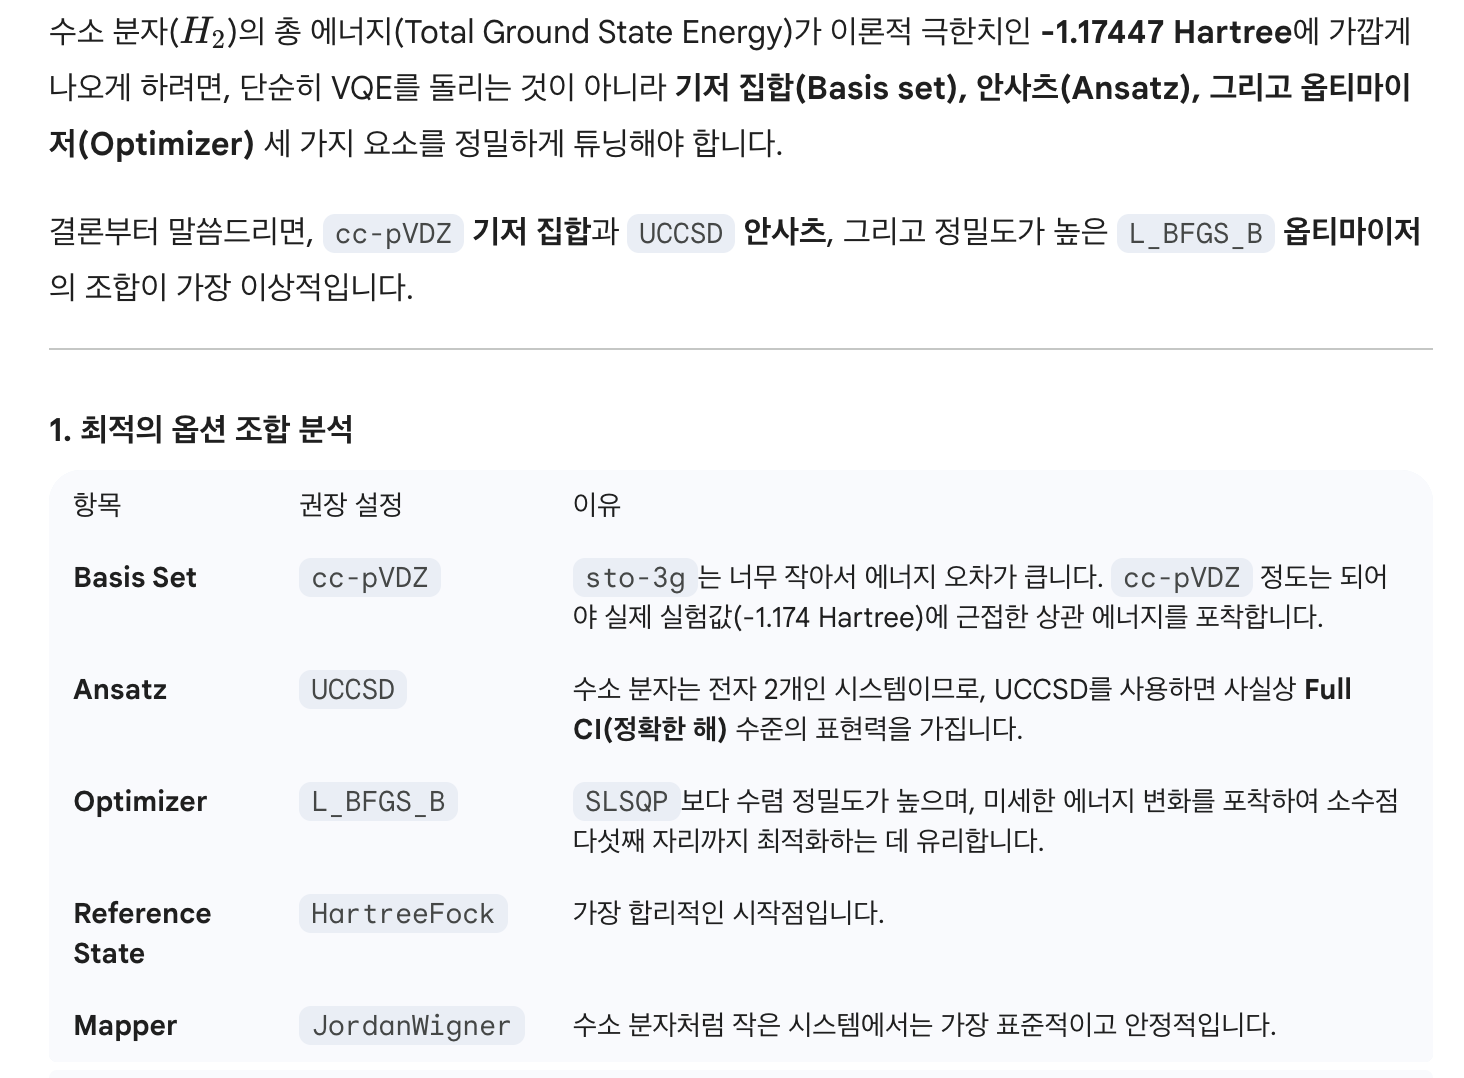